Описание данных.

В данной лабораторной работе будет рассматриваться датасет с клиентами банков. Каждый клиент банка характеризуется рядом признаков:

CUST_ID: Идентификация держателя кредитной карты (категория)

BALANCE: сумма баланса, оставшаяся на их счету для совершения покупок.

PURCHASES: количество покупок, совершенных с аккаунта.

INSTALLMENTS_PURCHASES: сумма покупки в рассрочку.

CASH_ADVANCE: наличный аванс, предоставленный пользователем

CREDIT_LIMIT: лимит кредитной карты для пользователя

PAYMENTS: Сумма платежа, сделанного клиентом

MINIMUM_PAYMENTS: минимальная сумма платежей пользователя.

TENURE: Срок обслуживания кредитной карты для пользователя

Для данной лабораторной работы мы не будем использовать CUST_ID, так как она не несет какой-либо информации в себе, а также TENURE, так как в данной выборке почти что у всех пользователей данный показатель находится на одном уровне и также является малоинформативном из-за данного факта

Выполнение работы.

Сначала подключаемся к облачному хранилищу для работы с файлом и подключаем все необходимые библиотеки.

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

CreditSet = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/credit_card.csv")

Сначала ознакомимся с датасетом и уберем из него лищние столбцы, в данном случае это столбцы с ID пользователя и Tenure. После этого ознакомимся с полученными данными, а также типом данных.

In [ ]:
df = CreditSet.drop(['CUST_ID', 'TENURE'], axis = 1)
print(df.dtypes)
df.sample(5)

BALANCE                   float64
PURCHASES                 float64
INSTALLMENTS_PURCHASES    float64
CASH_ADVANCE              float64
CREDIT_LIMIT              float64
PAYMENTS                  float64
MINIMUM_PAYMENTS          float64
dtype: object


,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
2280,1689.319684,724.83,724.83,0.000000,1500.0,1462.037592,3397.732291
3494,951.675294,0.00,0.00,1090.520215,1200.0,178.362607,340.410195
8826,33.725413,388.44,388.44,0.000000,1000.0,317.537207,127.402267
5791,1851.622011,200.00,0.00,152.692363,2000.0,712.340210,798.280589
8097,39.930624,399.95,109.38,0.000000,1200.0,0.000000,312.343947


Далее проведем нормализацию данных с помощью метода StandartScaler

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
X = df.values[:]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


Заранее воспользуемся сжатием признакого пространства с помощью метода TSNE, так как это позволит нам создавать удобную для восприятия визуализацию кластеров. Также с помощью данной сжатой выборки попробуем обучить модели, чтобы увидеть будет ли какая-то разница или нет.

In [ ]:
from sklearn.manifold import TSNE
X_scaled_TSNE = TSNE(n_components = 2, random_state = 1).fit_transform(X_scaled)

Аналогичным образом воспользуемся методом главных компонент, его мы будем использовать для обучения модели.

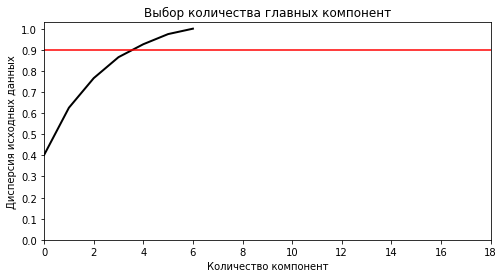

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA().fit(X_scaled)
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.title('Выбор количества главных компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Дисперсия исходных данных')
plt.xlim(0, 18)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(0.9, c='r')
plt.show();


Согласно данному методу, оптимальное количество признаков для данного набора данных равняется 4. В итоге получаем массив сокращеной размерности 

In [ ]:
pca = PCA(n_components=4)
pca.fit(X_scaled)
X_scaled_pca = pca.transform(X_scaled)
print("Форма исходного массива: {}".format(str(X_scaled.shape)))
print("Форма массива после сокращения размерности: {}".format(str(X_scaled_pca.shape)))

Форма исходного массива: (8950, 7)
Форма массива после сокращения размерности: (8950, 4)


Далее с помощью метода локтя определим оптимальное количество кластеров

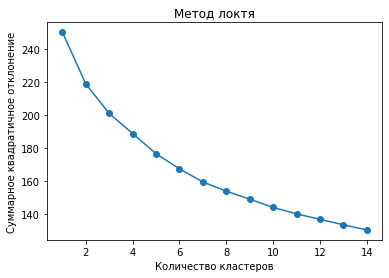

In [ ]:
from sklearn.cluster import KMeans
inertia = []
for k in range(1, 15):
 kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled)
 inertia.append(np.sqrt(kmeans.inertia_))
plt.figure()
plt.plot(range(1, 15), inertia, marker='o');
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Суммарное квадратичное отклонение')
plt.show()



Полученный график является достаточно плавным, однако с большой вероятностью на локоть похожа вторая точка, то есть оптимальное количество кластеров равняетася 2.

Далее начнем кластеризацию. Для этого воспользуемся методом к ближайших соседей и обучим его по трем разным выборкам:

1) Обычной

2) Выборка полученная TSNE

3) Выборка полученная методом главных компонент

Оценивать качество полученной кластеризации мы будем с помощью метода силуэтов, так как наша выборка является неразмеченной и классы объектов нам заранее неизвестны.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=1)
predK = kmeans.fit_predict(X_scaled)
labels = kmeans.labels_
print(labels)


После получения меток классов, передаем их в дата сет для проведения дальнейшей визуализации.

In [ ]:
df['Clus_km'] = labels
df.head()

,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,Clus_km
0,40.900749,95.40,95.4,0.000000,1000.0,201.802084,139.509787,0
1,3202.467416,0.00,0.0,6442.945483,7000.0,4103.032597,1072.340217,1
2,2495.148862,773.17,0.0,0.000000,7500.0,622.066742,627.284787,0
3,1666.670542,1499.00,0.0,205.788017,7500.0,0.000000,312.343947,0
4,817.714335,16.00,0.0,0.000000,1200.0,678.334763,244.791237,0


Также проведем группировку и посмотрим общие значения для выделенных классов.

Так класс 0 можно определить как менее платежеспособного клиента банка, так как все показатели ниже чем у клиентов, которым был присвоен класс 1

In [ ]:
df.groupby('Clus_km').mean().sort_values(by = 'BALANCE')

,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
Clus_km,,,,,,,
0,973.413915,683.040975,302.413307,541.783174,3576.105457,1110.557106,543.803960
1,4950.853892,2837.527090,1033.583474,3483.089228,9754.815448,5300.144605,2570.022097


Так в нашей выборке заранее не присвоены классы, то для оценки качества модели воспользуемся методом силуэтов

In [ ]:
from collections import defaultdict

compare = defaultdict(str)

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
sil = silhouette_score(X_scaled, labels)
compare['Kmeans_sil'] = sil 
print(f"Оценка = {sil}")

Оценка = 0.558003414027901


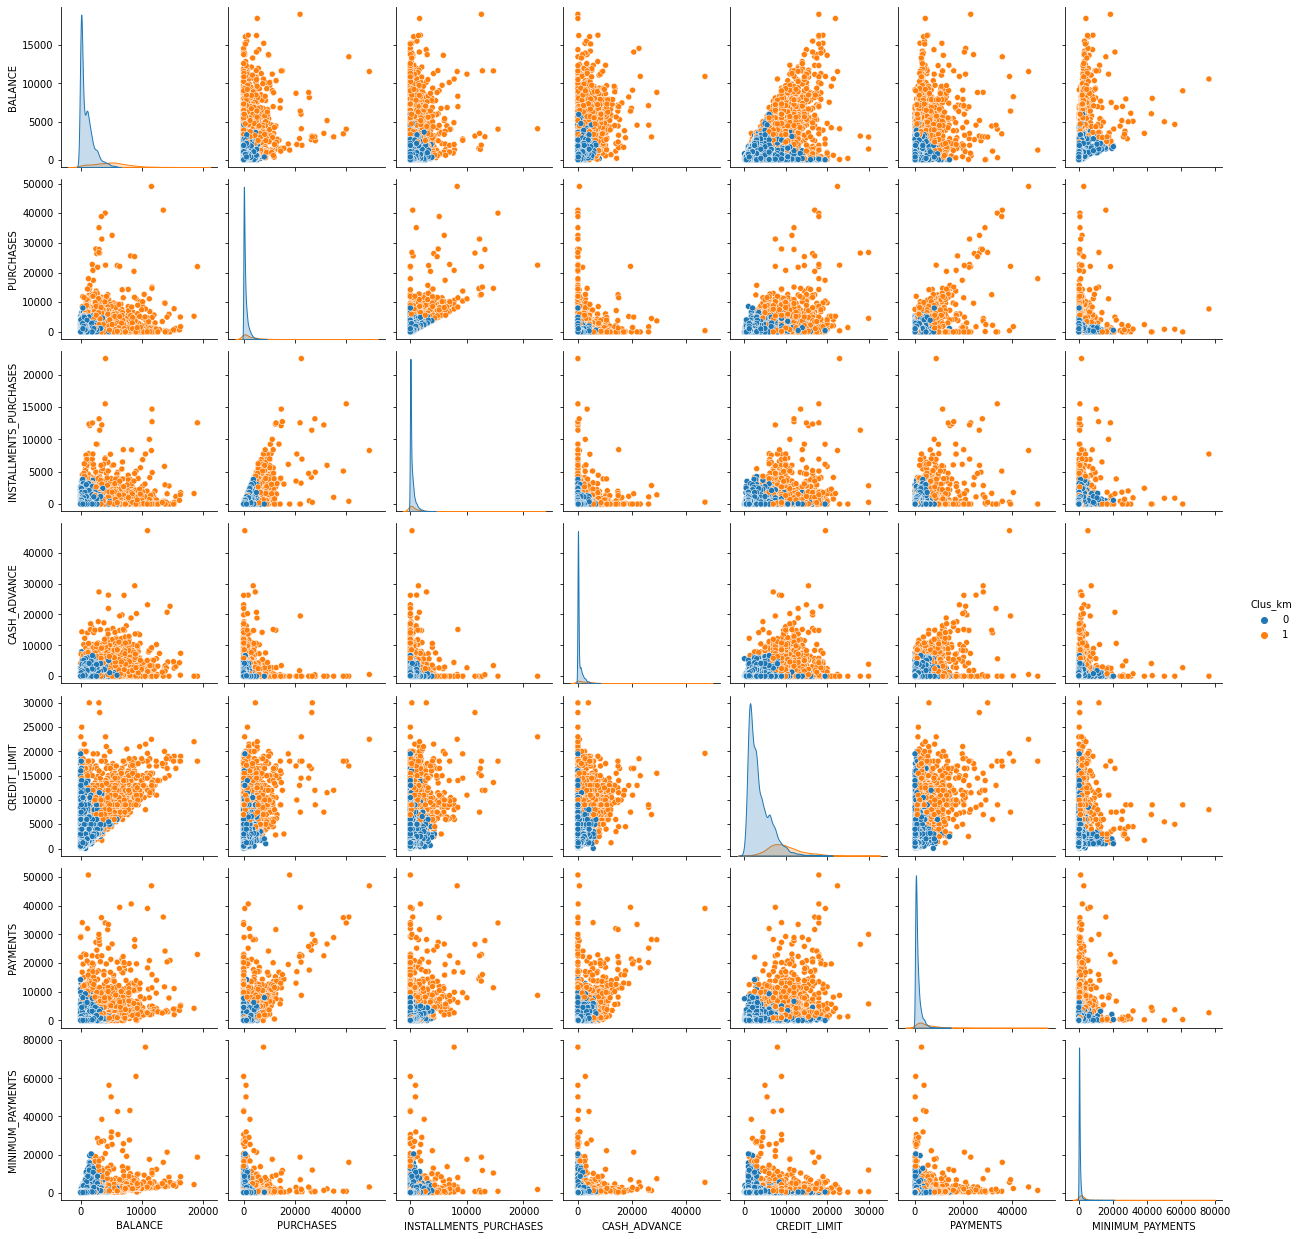

In [ ]:
import seaborn as sns
sns.pairplot(df, hue = 'Clus_km')

Как видно из графиков выше, кластеры с менее платежеспособным клиентам находятся в самом начале координат 

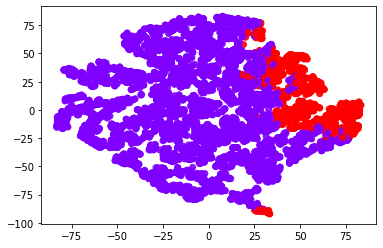

In [ ]:
plt.scatter(X_scaled_TSNE[:, 0], X_scaled_TSNE[:, 1], c=predK, cmap='rainbow', alpha=0.9)

Аналогично проведем обучение с выборкой TSNE и PCA и сравним результаты с помощью метода силуэтов

Оценка = 0.36692601442337036


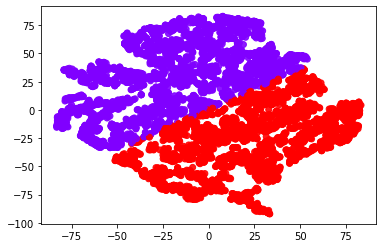

In [ ]:
predK_TSNE = kmeans.fit_predict(X_scaled_TSNE)
labelsTSNE = kmeans.labels_
df['Clus_km'] = labelsTSNE
plt.scatter(X_scaled_TSNE[:, 0], X_scaled_TSNE[:, 1], c=predK_TSNE, cmap='rainbow', alpha=0.9)
sil = silhouette_score(X_scaled_TSNE, labelsTSNE)
compare['Kmeans_sil_TSNE'] = sil 
print(f"Оценка = {sil}")


In [ ]:
predK_PCA = kmeans.fit_predict(X_scaled_pca)
labelsPCA = kmeans.labels_
df['Clus_km'] = labelsPCA

sil = silhouette_score(X_scaled_pca, labelsPCA)
compare['Kmeans_sil_PCA'] = sil 
print(f"Оценка = {sil}")


Оценка = 0.5843889192918228


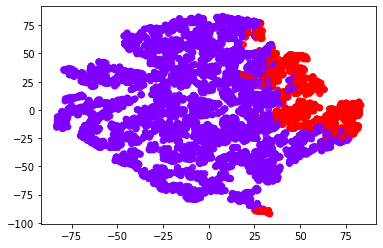

In [ ]:
plt.scatter(X_scaled_TSNE[:, 0], X_scaled_TSNE[:, 1], c=predK_PCA, cmap='rainbow', alpha=0.9)

In [ ]:
for label in compare:
  print(f'{label.ljust(15)} silhouette_score: {round(compare[label], 4)} ')

Kmeans_sil      silhouette_score: 0.558 
Kmeans_sil_TSNE silhouette_score: 0.3668999969959259 
Kmeans_sil_PCA  silhouette_score: 0.5844 


Как мы видим из значений выше, сжатие признакового пространства дало ухудшение метода силуэтов с использованием метода TSNE, что в данном случае логично, так как у нас малое количество изначальных признаков и мы теряем часть информации, отбрасывая часть признаков. Однако в то же время метод главных компонент улчушил показатель, что может говорить о наличии шумовых данных в представленной выборке.

Далее вопсользуемся методов Аггломеративной Кластеризации и посмотрим на результаты применения данного метода.

In [ ]:
from sklearn.cluster import AgglomerativeClustering


In [ ]:
model = AgglomerativeClustering(n_clusters = 2)
model.fit(X_scaled)
pred = model.fit_predict(X_scaled)



In [ ]:
df['Clus_km'] = model.labels_
df.groupby('Clus_km').mean().sort_values(by = 'BALANCE')

,BALANCE,PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
Clus_km,,,,,,,
1,697.806252,565.243743,269.989035,359.186252,3242.950642,832.846529,392.812620
0,3583.477291,2023.484725,739.726220,2422.497079,7409.401493,3830.488285,1898.111211


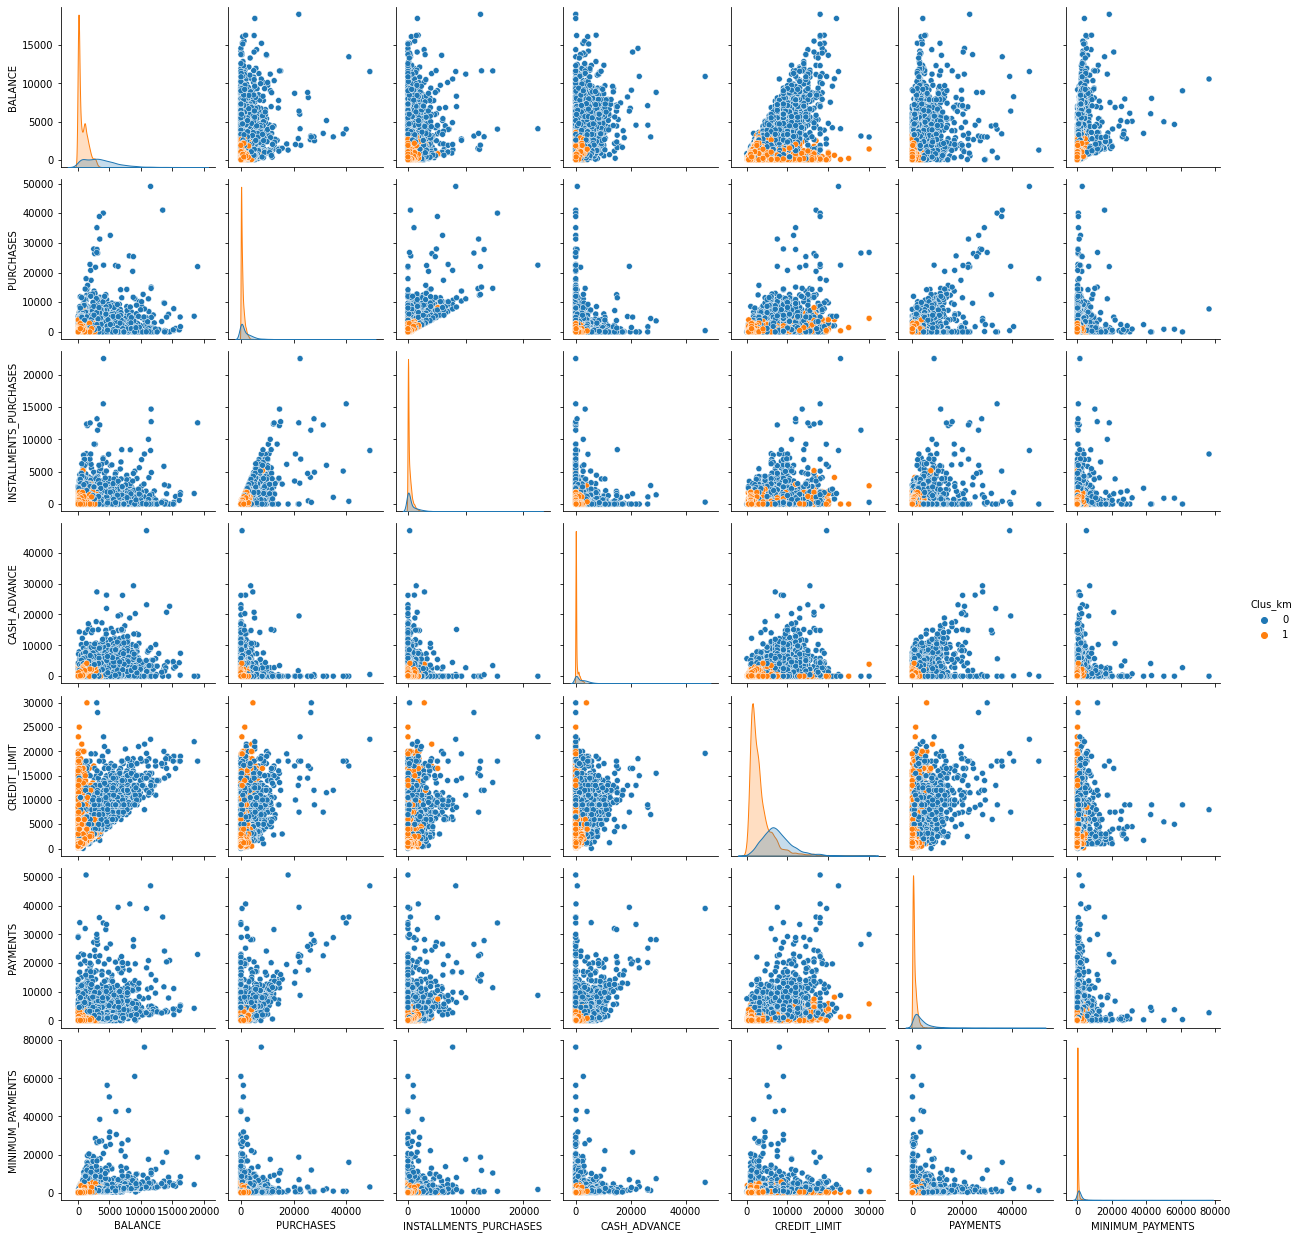

In [ ]:
sns.pairplot(df, hue = 'Clus_km')

Как видно из парного графика выше, кластеры распределились аналогичным образом. Однако на общем графике, расположенном ниже, уже видно отличие по сравнению с методом К-ближайших соседей.

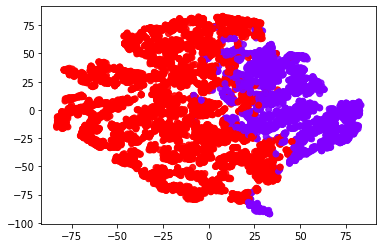

In [ ]:
plt.scatter(X_scaled_TSNE[:, 0], X_scaled_TSNE[:, 1], c=pred, cmap='rainbow', alpha=0.9)

In [ ]:
sil = silhouette_score(X_scaled, model.labels_)
compare['Agl_sil'] = sil 
print(f"Оценка = {sil}")

Оценка = 0.4041790361916944


Метод силуэтов дал нам оценку хуже, нежели методом К-ближайших соседей. Аналогичным образом протестируем данный метод с выборками TSNE и PCA и сравним полученные результаты

Оценка = 0.28022465109825134


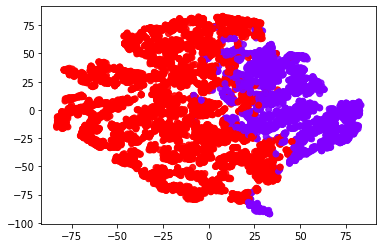

In [ ]:
modelAC_TSNE = AgglomerativeClustering(n_clusters = 2).fit(X_scaled_TSNE)
labelsTSNE = modelAC_TSNE.labels_
predAC_TSNE = model.fit_predict(X_scaled)
df['Clus_km'] = labelsTSNE
plt.scatter(X_scaled_TSNE[:, 0], X_scaled_TSNE[:, 1], c=predAC_TSNE, cmap='rainbow', alpha=0.9)

sil = silhouette_score(X_scaled_TSNE, labelsTSNE)
compare['Agl_sil_TSNE'] = sil 
print(f"Оценка = {sil}")

Оценка = 0.6397660033015057


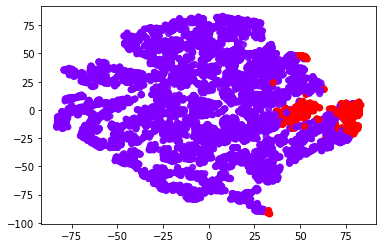

In [ ]:
modelAC_PCA = AgglomerativeClustering(n_clusters = 2).fit(X_scaled_pca)
labelsPCA = modelAC_PCA.labels_
predAC_PCA = modelAC_PCA.fit_predict(X_scaled_pca)

df['Clus_km'] = labelsPCA
silhouette_score(X_scaled_pca, labelsPCA)
plt.scatter(X_scaled_TSNE[:, 0], X_scaled_TSNE[:, 1], c=predAC_PCA, cmap='rainbow', alpha=0.9)

sil = silhouette_score(X_scaled_pca, labelsPCA)
compare['Agl_sil_PCA'] = sil 
print(f"Оценка = {sil}")

Как видно из результатов выше, метод TSNE дал ухудшение результатов, в то время как метод главных компонент улучших метрику силлуэтов.

Сравним все результаты и выберем наилучший вариант из имеющихся

In [ ]:
for label in compare:
  print(f'{label.ljust(15)} silhouette_score: {round(float(compare[label]), 2)}')

Kmeans_sil      silhouette_score: 0.56
Kmeans_sil_TSNE silhouette_score: 0.37
Kmeans_sil_PCA  silhouette_score: 0.58
Agl_sil         silhouette_score: 0.4
Agl_sil_TSNE    silhouette_score: 0.28
Agl_sil_PCA     silhouette_score: 0.64


Таким образом, наилучший результат был получен с помощью метода аггломеративной кластеризации и использования метода главных компонент. При этом в обоих случаях данных метод дал прирост по метрике качества.

Далее проведем сравнения результатов метода сжатия признакового пространства (TSNE) на примере выборки, в которой уже заранее известны классы. Для этого рассматорим выборку с диабетом из прошлого занятия.


In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
def some_metrics(y_test, X_pred):
    accuracy = accuracy_score(y_test, X_pred)
    precision = precision_score(y_test, X_pred)
    recall = recall_score(y_test, X_pred)
    f1 = f1_score(y_test, X_pred)
    roc_auc = roc_auc_score(y_test, X_pred)
    return [accuracy, precision, recall, f1, roc_auc]

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
DiabetSet = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/diabetes (1).csv")
DiabetSet = DiabetSet.astype({'Outcome': 'category'})
Indexes = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for line in range(len(DiabetSet)):
  for col in range(1, len(DiabetSet.loc[line])-1):
    if DiabetSet.loc[line, Indexes[col]] == 0:
      DiabetSet.loc[line, Indexes[col]] = DiabetSet.groupby(['Outcome']).mean().loc[DiabetSet.loc[line, 'Outcome'], Indexes[col]]
categorical_columns = [c for c in DiabetSet.columns if DiabetSet[c].dtype.name == 'category']
numerical_columns   = [c for c in DiabetSet.columns if DiabetSet[c].dtype.name != 'category']
data_numerical = DiabetSet[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
data = pd.concat((data_numerical, DiabetSet[categorical_columns]), axis=1)

X = data.drop(('Outcome'), axis=1)
y = data['Outcome']

X = (X - X.mean()) / X.std()

feature_names = X.columns

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_TSNE = TSNE(n_components = 2, random_state = 1).fit_transform(X_scaled)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_scaled_TSNE, y, test_size = 0.3, random_state = 11)

Accuracy: 0.7142857142857143
Precision: 0.6212121212121212
Recall 0.5
F1: 0.5540540540540541
ROC_AUC: 0.6661073825503355
Confusion matrix, without normalization
[[124  25]
 [ 41  41]]


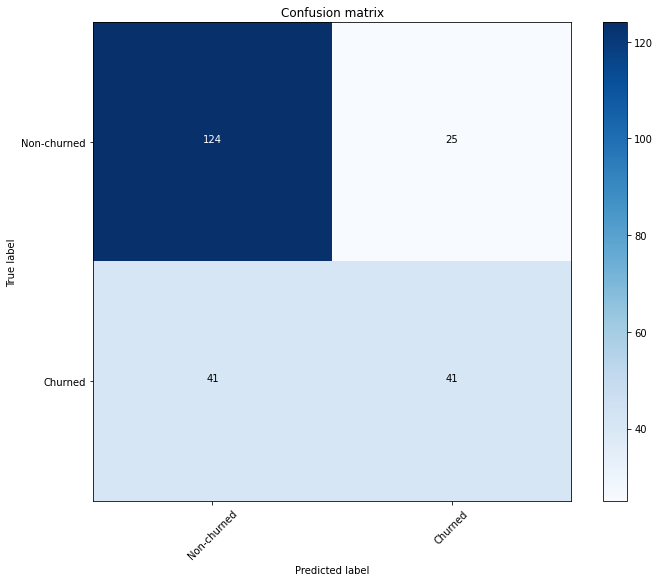

In [ ]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train, y_train)

cnf_matrix = confusion_matrix(y_test, rf.predict(X_test))

metric = some_metrics(y_test, rf.predict(X_test))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

В предвдущем исследовании данной выборки были получены следующие результаты:

rf Accuracy: 0.8442 Precision: 0.8108 Recall 0.7317 F1: 0.7692 ROC_AUC: 0.8189

Как мы видим, в данном случае произошло ухудшение всех показателей, что, как отмечалось выше, связано с потерей части данных из-за сжатия.
